# Single Image: Dark Regions Identification

In [35]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from scipy.ndimage import distance_transform_edt
from astropy.visualization import (MinMaxInterval, ImageNormalize)
from astropy.io import fits as fits
from astropy.wcs import WCS
from astropy.utils import data as data_utils
from astropy.coordinates import SkyCoord

import sep
sep.set_extract_pixstack(1000000)

# version dependencies are currently an issue
import pkg_resources
pkg_resources.require("numpy==1.26.4")
import numpy as np

import pandas as pd

## Image Query
Querying a single image from the DESI legacy survey. 

In [36]:
def obtain_image(brick, filter="g", reset_cache=True):
    """Returns the header and data for a coadded FITS file queried from the Legacy Survey DR10 portal
    
    Files are accessed with a url pattern of `<section>/<brick>/legacysurvey-<brick>-image-<filter>.fits.fz`
    as documented on the [Legacy Survey website](https://www.legacysurvey.org/dr10/files/#image-stacks-south-coadd).
    Images can be deleted from cache after the header and data are extracted.
    
    Parameters
    ----------
    brick:  `str`
        Brick name of image: RRRr(p/m)DDd
    filter: `str`
        Photographic filter of image to request (g, r, i, z)
    reset_cache: `bool`, default `True`
        Clears the downloaded image from the cache
        
    Returns
    -------
    header: `CompImageHeader`
        Astropy object of the FITS header data
    data: `ndarray`
        Numpy NDarray of FITS image data
    """
    
    url = "https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr10/south/coadd/"
    image_string = url + f"{brick[0:3]}/{brick}/legacysurvey-{brick}-image-{filter}.fits.fz"
    
    print(f"Downloading {image_string}....")

    # assumes only one image, in the first non-primary header file
    with fits.open(image_string) as hdu:
        image = hdu[1]
        header = image.header
        data = image.data
    
    if reset_cache:
        print("Clearing download cache...")
        data_utils.clear_download_cache(image_string)
    
    return image, header, data

image, header, data = obtain_image("2139p192", "g", reset_cache=False)

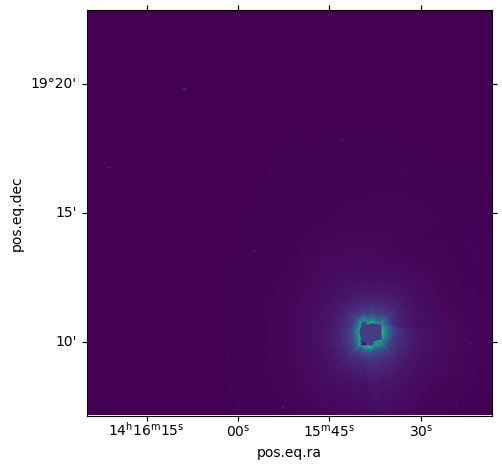

In [37]:
def plot_image():
    """Plots the image based on header and image data"""
    
    wcs = WCS(header)
    ra = header['CRVAL1']
    dec = header['CRVAL2']

    plt.figure()
    ax = plt.subplot(111, projection=wcs)
    ax.imshow(data, norm='linear')

    plt.tight_layout()

    return wcs, ra, dec
    
wcs, ra, dec = plot_image()

## Thresholding

There are a few components to calculating 'threshold' value for source extraction. We need to consider subtraction of background noise to identify objects, but then also enforce the limiting magnitude of 21. Start by extracting values from the image header about global background and zero point, and define the limiting magnitude.

In [38]:
def thresh_values(mag_limit=21):
    """Pull out the three relevant values for calculating threshold required for source extraction. Uses SEP for background subtraction.

    The average background of the image can be taken as a single number average, or an array by pixel. Here, we have taken a single number average for simplicity.
    
    Parameters
    ----------
    mag_limit : `float`, optional
        Limiting magnitude of instrument, after which point objects will not be detected. Default is 21, the limit of the ANU 2.3m telescope.

    Returns
    -------
    sigma_gb : `float`
        Global RMS of the image background
    mag_zero : `float'
        Astropy object of the FITS header data, contains zero point of image
    mag_limit : `int`
        Limiting magnitude of instrument
    """

    # single number background average
    bkg = sep.Background(data)
    sigma_gb = bkg.globalrms

    # zero point
    mag_zero = header['MAGZERO']

    return (sigma_gb, mag_zero, mag_limit)

The threshold function calculates the value to use in the SEP source extraction function, based on the background RMS of the original image data.
$$a = \frac{1}{\sigma_{rms}} 10^{(z-m)/2.5}$$

- $a$: threshold value to input into source extractor
- $\sigma_{rms}$: background RMS found from previous function
- $z$: (AB) magnitude zero point of image (22.5 for all DR10 stacked images)
- $m$: limiting (AB) magnitude to define the threshold by

In [39]:
def threshold_func():
    """ Function to calculate threshold for SEP.

    Returns
    -------
    threshold :  `float`
        Value calculated from background, zero point and limiting magnitude for the threshold for object detection
    """

    threshold_values = thresh_values()
    threshold = (1 / (threshold_values[0])) * (10 ** ((threshold_values[1] -  threshold_values[2]) / 2.5))
    return threshold

Finally, run the thresholding function on the given image to find the threshold value.

In [40]:
thresh = threshold_func()
print("Threshold: ", thresh)

Threshold:  351.43067610184664


## Source Extraction
Now that we have our threshold which takes into account our magnitude limit and global background for the image, we can run source extraction from SEP to pull out objects that meet this threshold. Note that the depth of the DESI survey is far greater than the 2.3, so objects may be identified that do not meet the limiting magnitude.

In [41]:
def source_exctract():
    objects = sep.extract(data, thresh, err=sep.Background(data).globalrms, segmentation_map=True)
    bkg_img = objects[0]
    seg_map = objects[1] # the boolean array of light/dark spots is what we need to create the segmentation map.

    return (bkg_img, seg_map)

bkg_image, seg_map = source_exctract()
len(bkg_image)

26

Plot the background-subtracted image, with ellipses around each object that meets the limiting magnitude.

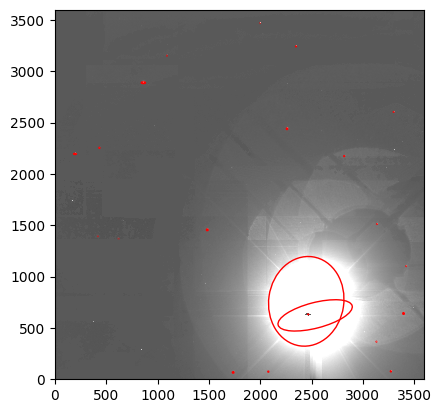

In [42]:
def plot_image():
    """"Plots the image in a modified colour scale with ellipses around detected objects """

    # Plots the image
    fig, ax = plt.subplots()
    m, s = np.mean(data), np.std(data)
    im = ax.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

    # plot an ellipse for each object
    for i in range(len(bkg_image)):
        e = Ellipse(xy=(bkg_image['x'][i], bkg_image['y'][i]),
                    width=5*bkg_image['a'][i],
                    height=5*bkg_image['b'][i],
                    angle=bkg_image['theta'][i] * 180. / np.pi)
        e.set_facecolor('none')
        e.set_edgecolor('red')
        ax.add_artist(e)

    return


plot_image()

Plot segmentation map with axes converted to sky coordinates rather than pixels. 

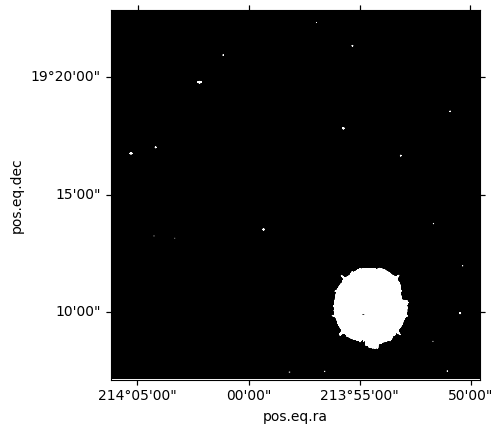

In [43]:
def plot_seg_map():
    """ Plots the segmentation map, given as an output in the source extraction step """
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection=wcs)
    plt.imshow(seg_map, origin='lower', cmap='grey', vmin=0, vmax=1)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_major_formatter('dd:mm:ss')
    lat.set_major_formatter('dd:mm:ss')

    return

plot_seg_map()

## Finding Dark Regions
Now expand the exclusion zones to a 20 arcsec radius around each object. The centre of the 2.3 FOV cannot be within these exclusion zones. We also add a grid with 45 arcsec diameter squares to demonstrate all the potential centres of the 2.3m FOV.

In [45]:
def exclusion_zones(pixscale=0.262, exclude_radius = 20):
    """ Calculating the exclusion zones around each identified object above threshold, based on viewer input radius.
    
    Parameters
    ----------
    pixscale : `float`, optional
        Conversion factor between pixels and sky coordinates. Default is 0.262 pixel/arcsec.
    """

    # Calculate the distance transform of the seg_map
    distance = distance_transform_edt(seg_map == 0,sampling=pixscale)

    # Expand seg_map for exclusion zones
    excl_map = np.copy(seg_map)
    excl_map[distance <= exclude_radius] = 1

    return excl_map, pixscale

excl_map, pixscale = exclusion_zones()

def define_grid(fov=45):
    
    gridscale = fov//float(exclusion_zones()[1])
    gridlines = np.arange(0,3600,gridscale)
    gridlines = gridlines.astype(int)

    return gridlines

gridlines = define_grid()

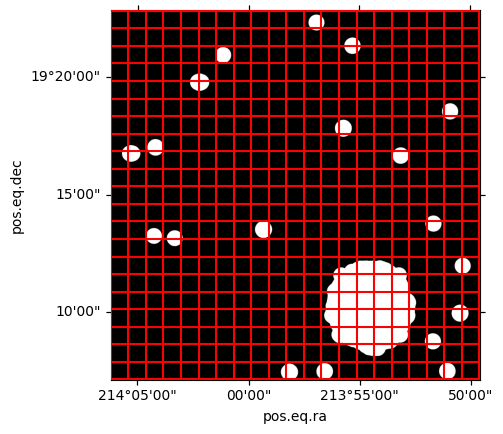

In [46]:
def create_grid():

    # Creating exclusion map with grid
    fig = plt.figure()
    ax = fig.add_subplot(111, projection=wcs)

    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_major_formatter('dd:mm:ss')
    lat.set_major_formatter('dd:mm:ss')
    lon.set_ticklabel(exclude_overlapping=True)
    lat.set_ticklabel(exclude_overlapping=True)

    norm = ImageNormalize(excl_map, MinMaxInterval())
    plt.imshow(excl_map, origin='lower', cmap='gray', aspect='equal', norm=norm)
    plt.vlines(gridlines,0,3600,colors='red')
    plt.hlines(gridlines,0,3600,colors='red')
    plt.margins(0)
    plt.show()

    return

create_grid()

The final step is to find the centre coordinate of every single grid square that does not have any exclusion zone in it. In this case, it is all squares except the bottom left corner. We locate these centres and plot an 'x' on each RADEC coordinate for dark sky regions.

In [47]:
def find_dark_regions():

    # calculating and storing the centre of each dark coord
    centers = []

    for i in range(len(gridlines[:-1])):
        centers.append(int((gridlines[i] + gridlines[i+1])/2 + 0.5))

    x_cen, y_cen = np.meshgrid(centers, centers)

    dark_regions = []

    for i in range(len(gridlines) - 1):
        for j in range(len(gridlines) - 1):
            x_start, x_end = gridlines[i], gridlines[i + 1]
            y_start, y_end = gridlines[j], gridlines[j + 1]
            
            if np.all(excl_map[y_start:y_end, x_start:x_end] == 0):
                dark_regions.append([x_cen[j, i], y_cen[j, i]])

    dr_trans = np.array(dark_regions).transpose()

    return dr_trans

dr_trans = find_dark_regions()

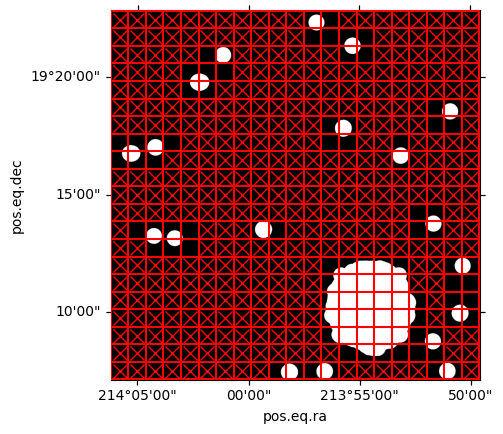

In [48]:
def plot_dark_regions():
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection=wcs)

    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_major_formatter('dd:mm:ss')
    lat.set_major_formatter('dd:mm:ss')
    lon.set_ticklabel(exclude_overlapping=True)
    lat.set_ticklabel(exclude_overlapping=True)

    norm = ImageNormalize(excl_map, MinMaxInterval())
    plt.imshow(excl_map, origin='lower', cmap='gray', aspect='equal', norm=norm)
    plt.vlines(gridlines,0,3600,colors='red')
    plt.hlines(gridlines,0,3600,colors='red')
    plt.margins(0)
    plt.plot(dr_trans[0], dr_trans[1], 'rx', markersize=10)
    plt.show()

    return

plot_dark_regions()

In [49]:
def dr_dataframe():

    # list of dark sky coords
    dark_x = []
    dark_y = []

    for i in range(len(dr_trans[0])):
        dark_x.append(dr_trans[1][i]*pixscale + ra)
        dark_y.append(dr_trans[0][i]*pixscale + dec)

    dark_coords = [dark_x, dark_y]

    ra_coords = []
    dec_coords = []

    c = SkyCoord(ra=dark_coords[0], dec=dark_coords[1], unit='arcsec')
    for i in range(len(c)):
        ra_coords.append(c[i].ra.degree)
        dec_coords.append(c[i].dec.degree)

    # create a data frame of coords list
    d = {'RA':ra_coords, 'DEC':dec_coords}
    df = pd.DataFrame(data=d)
    
    return df

df = dr_dataframe()

df
len(df)

347